# Metric Presentation and Visualization

In [58]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
import scienceplots
plt.style.use('science')

from discriminative_metrics import discriminative_score_metrics
from predictive_metrics import predictive_score_metrics
from metric_utils import generate_ks_results, visualization, display_scores

In [59]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

## Data Loading

In [60]:
# specify the --name argument
experiment_name = "weather"

In [61]:
iterations = 5
real_data = np.load(f'../data/real_paths/{experiment_name}.npy')
generated_data = np.load(f'../data/generated_paths/{experiment_name}.npy')

In [62]:
# minmax scale the inputs for fair comparison
data_min = np.min(real_data, axis=(0,1), keepdims=True)
data_max = np.max(real_data, axis=(0,1), keepdims=True)

real_data = (real_data - data_min) / (data_max - data_min)
generated_data = (generated_data - data_min) / (data_max - data_min)

In [63]:
# test set
real_data = real_data[-1000:]

In [64]:
num_samples, seq_len, dim = real_data.shape
real_data.shape, generated_data.shape

((1000, 1000, 14), (1000, 1000, 14))

## Discriminative and Predictive Scores

In [65]:
discriminative_score = []

for i in range(iterations):
    temp_disc, fake_acc, real_acc = discriminative_score_metrics(real_data, generated_data)
    discriminative_score.append(temp_disc)
    print(f'Iter {i}: ', temp_disc, '\n')
      
print(f'{experiment_name}:')
display_scores(discriminative_score)
print()

training: 100%|██████████| 2000/2000 [00:51<00:00, 38.66it/s]


Iter 0:  0.4275 



training: 100%|██████████| 2000/2000 [00:48<00:00, 40.97it/s]


Iter 1:  0.4375 



training: 100%|██████████| 2000/2000 [00:52<00:00, 37.86it/s]


Iter 2:  0.345 



training: 100%|██████████| 2000/2000 [00:48<00:00, 41.15it/s]


Iter 3:  0.4075 



training: 100%|██████████| 2000/2000 [00:48<00:00, 41.34it/s]

Iter 4:  0.45999999999999996 

weather:
Final Score:  0.4154999999999999 ± 0.03909603560464923



In [66]:
predictive_score = []
for i in range(iterations):
    temp_pred = predictive_score_metrics(real_data, generated_data)
    predictive_score.append(temp_pred)
    print(i, ' epoch: ', temp_pred, '\n')
      
print(f'{experiment_name}:')
display_scores(predictive_score)
print()

training: 100%|██████████| 5000/5000 [00:31<00:00, 160.79it/s]


0  epoch:  0.16664761397242547 



training: 100%|██████████| 5000/5000 [00:32<00:00, 156.12it/s]


1  epoch:  0.1660346100628376 



training: 100%|██████████| 5000/5000 [00:29<00:00, 170.90it/s]


2  epoch:  0.16730343060195446 



training: 100%|██████████| 5000/5000 [00:29<00:00, 167.50it/s]


3  epoch:  0.16548391329869627 



training: 100%|██████████| 5000/5000 [00:29<00:00, 169.14it/s]


4  epoch:  0.16669204917922617 

weather:
Final Score:  0.166432323423028 ± 0.0006213361227352971



## KS Test Scores on Marginals

In [67]:
pct_marginals = (0.3, 0.5, 0.7, 0.9)
real_dataloader = DataLoader(TensorDataset(torch.tensor(real_data)), batch_size=64, shuffle=True)
generated_dataloader = DataLoader(TensorDataset(torch.tensor(generated_data)), batch_size=64, shuffle=True)
infinite_real_dataloader = (elem for it in iter(lambda: real_dataloader, None) for elem in it)
infinite_generated_dataloader = (elem for it in iter(lambda: generated_dataloader, None) for elem in it)
ks_results = generate_ks_results(infinite_real_dataloader, infinite_generated_dataloader, pct_marginals, 1000, dims=dim)
ks_stats = ks_results[:,:,:,0]
ks_pvals = ks_results[:,:,:,1]

In [68]:
mean_score = np.mean(ks_stats, axis=0)
std_score = np.std(ks_stats, axis=0)
percent_reject = np.mean(ks_pvals <= 0.05, axis=0)
# print as a table
mean_score_per_marginal = np.mean(mean_score, axis=0)
std_score_per_marginal = np.mean(std_score, axis=0)
mean_pct_reject_per_marginal = np.mean(percent_reject, axis=0)
print('KS Test:')
print('Marginal\tMean KS\t% Reject')
for i, pct in enumerate(pct_marginals):
    print(f'{pct}\t{mean_score_per_marginal[i]:.2f}\t{mean_pct_reject_per_marginal[i]*100:.2f}')

KS Test:
Marginal	Mean KS	% Reject
0.3	0.35	83.01
0.5	0.35	82.24
0.7	0.34	79.19
0.9	0.34	80.66


## t-SNE Plots

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.028s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.277450
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.116325
[t-SNE] KL divergence after 300 iterations: 1.917062


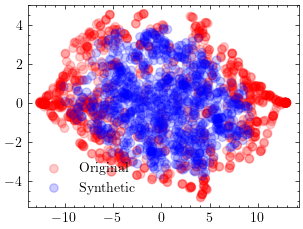

In [69]:
visualization(real_data, generated_data, "tsne")